In [2]:
import os
import math
import torch
import torch.nn as nn
import torch.autograd as ag
import torch.optim as optim
import torchvision
import numpy as np
import time
from torchvision import models
import ASDC_loader
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
#device = torch.device('cpu')


cuda


In [3]:
# Data set
# train_dataset = ASDC_loader.ASDC_Crop_Class_Dataset(dataset='train', truncate=-1, crop=(256,256))
# print(len(train_dataset.imageIDs))
# max_idx = 192555

def make_val_ranges(max_idx, num_sets, current_num, rand=None):
    end = max_idx
    cur = current_num # range of [0, n)
    if rand is None:
        seg_len = int(np.ceil(end/num_sets))
        train_range = list(range(0, (cur)*seg_len)) + list(range((cur+1)*seg_len, max_idx))
        val_range = range((cur)*seg_len, end if cur==num_sets-1 else (cur+1)*seg_len)
        return train_range, val_range
    else:
        raise NotImplementedError

In [4]:

truncate_len = 192555
truncate_len = 160000
# truncate_len = 6000
train_range, val_range = make_val_ranges(truncate_len, 4, 0)
print(len(train_range))
print(len(val_range))

train_dataset = ASDC_loader.ASDC_Crop_Class_Dataset(dataset='train', ID_idxs=train_range, truncate=truncate_len, crop=(256,256))
val_dataset = ASDC_loader.ASDC_Crop_Class_Dataset(dataset='validate', ID_idxs=val_range, truncate=truncate_len, crop=(256,256))

120000
40000


In [5]:
def onehot2label(d):
    lbl = d.argmax(dim=1)
    return lbl

def eval_class_dataset(model, loader):
    model.eval()
    num_correct = 0.0
    for idx, (images, labels) in enumerate(loader):
        images = images.to(device)
        labels = labels.to(device)
        pred = model(images)
        pred_labels = onehot2label(pred)
        num_correct += torch.sum(labels==pred_labels)
#         if idx%100 == 99:
    #         print("{:d}: {:f}".format(idx, num_correct/num_total))
#              print("{:d}: {:f}".format(idx, num_correct))
    accuracy = float(num_correct)/len(loader.dataset)
    model.train()
    return accuracy

In [6]:
def save_whole_checkpoint():
    ASDC_loader.save_checkpoint(param_path, 
                                model=model, 
                                optimizer=optimizer, 
                                epoch=epoch, 
                                idx=idx, 
                                B=B, 
                                losses=losses, 
                                train_accs=train_accs,
                                val_accs=val_accs)            

In [7]:
class AlexNet(nn.Module):
    ranges = ((0, 3), (3, 6), (6, 8), (8, 10), (10, 13))
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        
        self.if_class = True
        self.ranges = AlexNet.ranges
        
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

        
        #Initilize the parameters
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
                
                
    def forward(self, x):
        if self.if_class:
            x = self.features(x)
            x = x.view(x.size(0), 256 * 7 * 7)
            output = self.classifier(x)
            
        else: 
            output = {}
            # get the output of each maxpooling layer (5 maxpool in VGG net)
            for idx in range(len(self.ranges)):
                for layer in range(self.ranges[idx][0], self.ranges[idx][1]):
                    x = self.features[layer](x)
                output["x%d"%(idx+1)] = x
            
        return output
 

    def remove_classifier(self):
        del self.classifier
        self.if_class = False

In [8]:
model = AlexNet(2).to(device) 

In [9]:
N = len(train_dataset) # Training set size 
B = 64 # Minibacth size
NB = int(N/B) # Number of minibatches
T = 13 # Number of epochs
gamma = .005 # learning rate
rho = .9 # momentum

# Data loader (this provides queues and threads in a very simple way).
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=B, 
                                           shuffle=True,
                                           num_workers=8)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=B, 
                                           shuffle=True,
                                           num_workers=8)

#test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
#                                           batch_size=B)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=gamma, momentum=rho)
print('done')

done


In [10]:
model.parameters()

<generator object Module.parameters at 0x7f2385d78990>

In [11]:
param_path = './alex_net_test_params.pt'

if not os.path.isfile(param_path):
    ASDC_loader.save_checkpoint(param_path, model=model, optimizer=optimizer)
    print('using new model')
else:
    print('using local model')

checkpoint_dict = ASDC_loader.load_checkpoint(param_path, model=model, optimizer=optimizer)
#print(checkpoint_dict)
# if 'B' in checkpoint_dict:
#     assert B == checkpoint_dict['B'], 'current minibatch size is %d, but saved size is %d' % (B, checkpoint_dict['B'])


using local model


In [11]:
model.train()

last_time = time.time()
print('start time: %f' % time.time())

losses = [] if 'losses' not in checkpoint_dict else checkpoint_dict['losses']
train_accs = [] if 'train_accs' not in checkpoint_dict else checkpoint_dict['train_accs']
val_accs = [] if 'val_accs' not in checkpoint_dict else checkpoint_dict['val_accs']

epoch = 0
while epoch < T:
    if 'epoch' in checkpoint_dict and epoch <= checkpoint_dict['epoch']:
        epoch += 1
        continue
    running_loss = 0.0
    scheduler_running_loss = 0.0
    epoch_time = time.time()
    
    for idx, (images, labels) in enumerate(train_loader):
#     train_iter = iter(train_loader) #dont use enumerate so that dataset.__getitem__ doesn't have to run
#     train_gen = ( minibatch for minibatch in train_loader )
#     print('done generator')
#     for idx in range(len(train_loader)):
        #check checkpoint to see if idx is already done
#         if 'idx' in checkpoint_dict and 'epoch' in checkpoint_dict:
#             if epoch <= checkpoint_dict['epoch'] and idx <= checkpoint_dict['idx']:
#                 continue    #skip ahead if already done in checkpoint
# #         images, labels = train_iter.next()
#         print(idx)

#         images, labels = train_gen[idx]

        #images = ag.Variable(images.to(device), requires_grad=True)
        #labels = ag.Variable(labels.to(device), requires_grad=False)
        
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        # loss
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print averaged loss per minibatch every 100 mini-batches
        running_loss += loss.item() 
        if idx % 100 == 99:
            print('[%d, %5d] loss: %.3f' % 
                  (epoch + 1, idx + 1, running_loss/100))
            losses.append((epoch, idx, running_loss/100))
            scheduler_running_loss += running_loss
            running_loss = 0.0 
            if idx <= 500:
                print('sec per sample: {:f}'.format((time.time()-last_time)/(B*100)))#time_per_sample = (last_time-time.time())/(B*100)
                last_time = time.time()


        
#         if time.time() > last_time + 5*60:    #save every 5 mins
#             save_whole_checkpoint()           
#             last_time = time.time()
#             print('saved at %f' % last_time)
            
        # Release RAM
        #torch.cuda.empty_cache()    
    last_time = time.time()
    print('[{:03d} {:05d}] epoch took {:02f} secs to run'.format(epoch+1, idx+1, time.time()-epoch_time))
        
    #evaluate accuracy
    tmp_time = time.time()
    train_acc = eval_class_dataset(model, train_loader)
    print('[{:03d} {:05d}] {:02f} secs to run \t training accuracy: {:04f}'.format(epoch+1, 
                                                                                   idx+1, 
                                                                                   time.time()-tmp_time, 
                                                                                   train_acc))
    train_accs.append((epoch, idx, train_acc))
        
    tmp_time = time.time()
    val_acc = eval_class_dataset(model, val_loader)
    print('[{:03d} {:05d}] {:02f} secs to run \t validati accuracy: {:04f}'.format(epoch+1, 
                                                                                   idx+1, 
                                                                                   time.time()-tmp_time, 
                                                                                   val_acc))
    val_accs.append((epoch, idx, val_acc))
    
    #done with one epoch
    save_whole_checkpoint()           
    print('saved at {:f}'.format(time.time()))
    
    epoch += 1
    
print('Finished Training')

start time: 1544686278.877045
[13,   100] loss: 0.061
sec per sample: 0.004393
[13,   200] loss: 0.060
sec per sample: 0.003876


Process Process-4:
Process Process-3:
Process Process-5:
Process Process-8:
Process Process-1:
Process Process-2:
Process Process-7:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/site-packages/torch

  File "/datasets/home/99/099/w1quan/.local/lib/python3.6/site-packages/imageio/core/format.py", line 174, in get_reader
    return self.Reader(self, request)
  File "/datasets/home/99/099/w1quan/.local/lib/python3.6/site-packages/imageio/plugins/pillow.py", line 125, in _open
    pil_try_read(self._im)
  File "/datasets/home/99/099/w1quan/.local/lib/python3.6/site-packages/imageio/core/format.py", line 224, in __init__
    self._open(**self.request.kwargs.copy())
  File "/datasets/home/99/099/w1quan/.local/lib/python3.6/site-packages/imageio/plugins/pillow.py", line 406, in _open
    return PillowFormat.Reader._open(self, pilmode=pilmode, as_gray=as_gray)
  File "/datasets/home/99/099/w1quan/.local/lib/python3.6/site-packages/imageio/plugins/pillow.py", line 501, in pil_try_read
    im.getdata()[0]
  File "/datasets/home/99/099/w1quan/.local/lib/python3.6/site-packages/imageio/plugins/pillow.py", line 125, in _open
    pil_try_read(self._im)
  File "/opt/conda/lib/python3.6/site-packa

Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-3f36b5ac1f70>", line 19, in <module>
    for idx, (images, labels) in enumerate(train_loader):
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 280, in __next__
    idx, batch = self._get_batch()
  File "/opt/conda/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 259, in _get_batch
    return self.data_queue.get()
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/opt/conda/lib/python3.6/multiprocessing/connect

KeyboardInterrupt: 

In [ ]:
# # checkpoint_dict
# it = iter(train_loader)
# print(len(it))
# len(train_loader)
# i, l = it.next()
# print(i.shape)
# print(l.shape)

In [ ]:
print(outputs.shape)

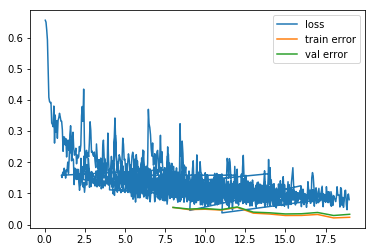

In [13]:
plt.figure()
max_idx = float(len(train_loader))
plot_losses = np.array([(epoch + idx/max_idx, loss) for epoch, idx, loss in checkpoint_dict['losses']])
plot_t_a = np.array([(epoch + idx/max_idx, loss) for epoch, idx, loss in checkpoint_dict['train_accs']])
plot_v_a = np.array([(epoch + idx/max_idx, loss) for epoch, idx, loss in checkpoint_dict['val_accs']])
plt.plot(plot_losses[:,0], plot_losses[:,1], label='loss')
plt.plot(plot_t_a[:,0], 1- plot_t_a[:,1], label='train error')
plt.plot(plot_v_a[:,0], 1- plot_v_a[:,1], label='val error')
legend = plt.legend(loc='upper right')

In [ ]:
plt.figure()
r = (0,15)
zoom = slice(r[0],r[1])
zoom_l = slice(r[0]*180,r[1]*180)
zoom = slice(':')
max_idx = float(len(train_loader))
plot_losses = np.array([(epoch + idx/max_idx, loss) for epoch, idx, loss in checkpoint_dict['losses']])
plot_t_a = np.array([(epoch + idx/max_idx, loss) for epoch, idx, loss in checkpoint_dict['train_accs']])
plot_v_a = np.array([(epoch + idx/max_idx, loss) for epoch, idx, loss in checkpoint_dict['val_accs']])
plt.plot(plot_losses[zoom_l,0], plot_losses[zoom_l,1], label='loss')
plt.plot(plot_t_a[zoom,0], 1- plot_t_a[zoom,1], label='train error')
plt.plot(plot_v_a[zoom,0], 1- plot_v_a[zoom,1], label='val error')
plt.ylim(0, 0.1)
legend = plt.legend(loc='upper right')


In [ ]:
print(len(plot_losses))
print(len(plot_t_a))

In [ ]:
plt.figure()
max_idx = float(len(train_loader))
plot_losses = np.array([(epoch + idx/max_idx, loss) for epoch, idx, loss in checkpoint_dict['losses']])
plot_t_a = np.array([(epoch + idx/max_idx, loss) for epoch, idx, loss in checkpoint_dict['train_accs']])
plot_v_a = np.array([(epoch + idx/max_idx, loss) for epoch, idx, loss in checkpoint_dict['val_accs']])
plt.plot(plot_losses[:,0], plot_losses[:,1], label='loss')
plt.plot(plot_t_a[:,0], 1- plot_t_a[:,1], label='train error')
plt.plot(plot_v_a[:,0], 1- plot_v_a[:,1], label='val error')
plt.ylim(0, 0.1)
legend = plt.legend(loc='upper right')

In [ ]:
raise # debug

In [ ]:
zoom*180

In [ ]:
### view images
idx2label = ASDC_loader.get_IN_labels()
idx2label[0] = 'ASDC_ship'
idx2label[1] = 'ASDC_background'

model.eval()

idxs = range(200000,200000+100,10)
print(idxs)
#idxs = [10]
for i in idxs:
    view_image, view_label = train_dataset[i]
    
    view_image = torch.unsqueeze(view_image, dim=0).to(device)
    view_label = torch.unsqueeze(torch.LongTensor([view_label]), dim=0).to(device)

    view_pred_labels = model(view_image)
    #print(labels.shape)
    title = 'pred: ' + str(view_label.item())
    
    plt.figure(i)
    plt.subplot(1,2,1)
    plt.imshow(ASDC_loader.torch2regular_image(view_image.cpu()[0,:,:,:]))
    plt.title(str(i))
    #cropped_image = ASDC_loader.crop_torch_image(image, (227,227))
    #print(cropped_image.shape)
    #plt.imshow(ASDC_loader.torch2regular_image(cropped_image[0,:,:,:]))
    #print(image.shape)
    plt.subplot(1,2,2)
    ship_mask = train_dataset.get_mask(i)
    plt.imshow(ship_mask[0,:,:])

    plt.title(title)


In [ ]:
raise

In [ ]:
type(optimizer)


In [ ]:
import math
print(loss)
#print(loss.data)
#print(loss.item()==torch.Tensor([float('nan')]).item())
print(math.isnan(loss.item()))
#print(type(torch.Tensor([float('nan')]).item()))

#print(float('nan')==float('nan'))


In [ ]:
print(labels.shape)
print(outputs.grad)

In [ ]:
print(str(model))
print(str(optimizer))

In [ ]:
print([key for key in checkpoint_dict])
print([ '{:s}: {:s}'.format(key, str(checkpoint_dict[key])) for key in ['model_type', 'optimizer_type', 'epoch', 'idx', 'B', 'losses', 'train_accs', 'val_accs'] ])
#print(checkpoint_dict['idx'])

In [ ]:
#val_dataset
# a = iter(val_loader)
# a = val_loader.__iter__()

# val_accuracy = eval_class_dataset(model, val_loader)
# train_accuracy = eval_class_dataset(model, train_loader)
print(val_accuracy)
print(train_accuracy)

In [12]:
def check_checkpoint_file(path, max_len=30):
    checkpoint_dict = ASDC_loader.load_checkpoint(path)
    for key in checkpoint_dict:
        val_str = str(checkpoint_dict[key])
        print('{:s}: {:s}'.format(key, val_str[:max_len]))

# check_checkpoint_file('alex_net_test_params.pt.back')

print('-----------------')

check_checkpoint_file('alex_net_test_params.pt')

-----------------
model_state_dict: OrderedDict([('features.0.weig
model_type: <class '__main__.AlexNet'>
optimizer_state_dict: {'state': {140233781343432: {'
optimizer_type: <class 'torch.optim.sgd.SGD'>
epoch: 11
idx: 18069
B: 8
losses: [(0, 99, 0.6562318813800812), 
train_accs: [(0, 18069, 0.9450374603086757
val_accs: [(0, 18069, 0.9450482965806438
